In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5"
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200


from hyperion.utils import cherenkov_ang_dist, calc_tres, cherenkov_ang_dist_int
import pickle

from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

from glob import glob
import json

from hyperion.data import DataLoader, SimpleDataset, create_random_split
from hyperion.models.photon_binned_amplitude.net import HistMLP, train_net, make_forward_fn, make_logp1_trafo

import haiku as hk

import jax.numpy as jnp
import optax
import functools

In [2]:
!rm -rf /tmp/tensorboard/runs/*

In [3]:
#for tts in [2, 3, 4]:
#for tts in [0]:
tts = 2
hists = pickle.load(open(f"data/combined_photon_hists_{tts}.pickle", "rb"))
inputs = np.asarray(hists[::2])
outputs = np.asarray(hists[1::2])
inputs = inputs.reshape((inputs.shape[0] * inputs.shape[1], 2))
outputs = outputs.reshape((outputs.shape[0] * outputs.shape[1], outputs.shape[-1]))

"""
bin_width = 1 # ns
noise_rate = 1E3 * 16 / 1E9
noise_hits =  noise_rate * bin_width

outputs += noise_hits
"""

#first_nonzero = jnp.argmax(outputs!=0, axis=1)

trafo, rev_trafo = make_logp1_trafo(1E18)

outputs = trafo(outputs)
#binning = jnp.arange(0, outputs.shape[1]+1)

binning = jnp.concatenate(
        [jnp.linspace(0, 10, 11), jnp.logspace(1, jnp.log10(500), 25)[1:]]
    )


inputs[:, 1] = jnp.log10(inputs[:, 1])
data = SimpleDataset(inputs, outputs, sanitize=False)
split = int(0.5*len(data))
rng = np.random.RandomState(2)
train_data, test_data = create_random_split(data, split, rng)



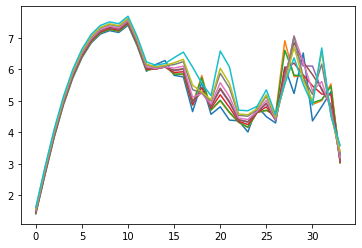

In [4]:
mins = np.argsort(np.min(outputs, axis=1))
plt.plot(outputs[mins[:10]].T);


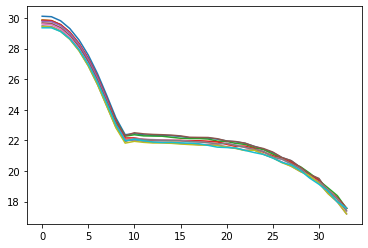

In [5]:
maxs = np.argsort(np.max(outputs, axis=1))[::-1]
plt.plot(outputs[maxs[:10]].T);


In [6]:
conf = {
        "batch_size" : 200,
        "n_in": 2,
        "n_out": outputs.shape[1],
        "dropout": 0.0,
        "final_activations": jax.nn.softplus,
        "lr": 0.01,
        "epochs": 700,
        "n_neurons": 500,
        "smoothnes_weight": 0
    }
writer = SummaryWriter(
    f"/tmp/tensorboard/runs/hist_test_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}_{conf['dropout']}_{conf['n_neurons']}"
)


net, params, state = train_net(conf, train_data, test_data, writer, rng)


In [10]:
pickle.dump([params, state, conf, binning, 1E18], open("data/arrival_hist_net_2tts_jax.pickle", "wb"))

params, state, conf, binning, trf_scale = pickle.load( open("data/arrival_hist_net_2tts_jax.pickle", "rb"))
forward_fn = make_forward_fn(conf)
net = hk.transform_with_state(forward_fn)

@jax.jit
def net_eval_fn(x):
    return net.apply(params, state, None, x, is_training=False)[0]



In [11]:
train_loader = DataLoader(
    train_data,
    batch_size=conf["batch_size"],
    shuffle=True,
    # worker_init_fn=seed_worker,
    rng=rng,
)


In [12]:
net_eval_fn(test_data[0]).shape

(1, 34)

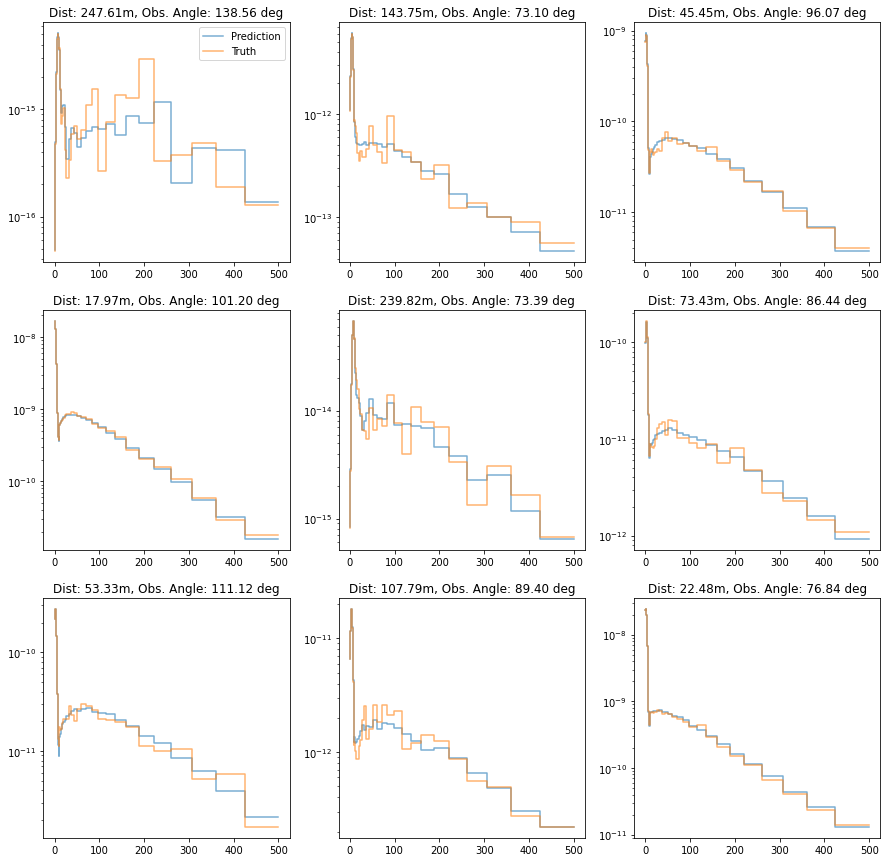

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

rng = np.random.RandomState(10)

ixs = rng.choice(len(test_data), size=9)


for ax, ix in zip(axs.ravel(), ixs):

    net_in = test_data[ix]
    nn_out = net_eval_fn(net_in)[0]
    truth = net_in[1][0]
    
    ax.step(binning, rev_trafo(np.append(nn_out, nn_out[-1])), alpha=0.6, label="Prediction", where="post")
    ax.step(binning, rev_trafo(np.append(truth, truth[-1])), alpha=0.6, label="Truth", where="post")

    ax.set_yscale("log")
    ax.set_title(f"Dist: {10**net_in[0][0][1]:.2f}m, Obs. Angle: {np.degrees(net_in[0][0][0]):.2f} deg")
    #ax.set_xlim(-30, 500)
    axs[0][0].legend()
    #ax.set_ylim(1E-18, 1E-6)

In [124]:
def interpolate_hist(hist, x, x_eval):
    
    dx = jnp.diff(x)
    dy = jnp.diff(hist)

    x_idx = jnp.searchsorted(x, x_eval, side="left") - 1
 
    interpolated = jnp.where(
        (x_idx >= 0) & (x_idx < x.shape[0] - 1),
        hist[x_idx] + dy[x_idx] / dx[x_idx] * (x_eval - x[x_idx]),
        jnp.nan,
    )

    interpolated = jnp.where(
        x_eval == x[0],
        hist[0],
        interpolated
    )

    return interpolated

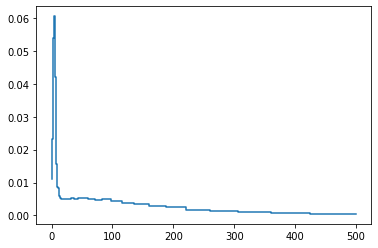

In [126]:
plt.figure()
plt.step(binning, 1E10*rev_trafo(np.append(nn_out, nn_out[-1])), where="post")

photons_per_bin = 1E10*rev_trafo(np.append(nn_out, nn_out[-1]))
photon_integral = np.cumsum(photons_per_bin)

(0.0, 2.0)

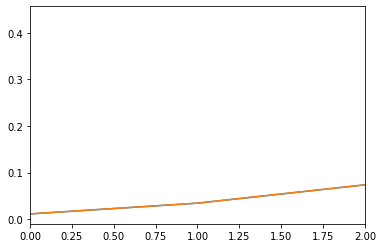

In [150]:
plt.plot(binning, photon_integral)
new_binning = jnp.linspace(0, 500, 5000)
#new_binning = binning
ipol= interpolate_hist(photon_integral, binning, new_binning)

plt.plot(new_binning, ipol)
#plt.semilogx()
plt.xlim(0, 2)

In [151]:
ipol[1], photon_integral[1]


(DeviceArray(0.01338627, dtype=float32),
 DeviceArray(0.03421976, dtype=float32))

DeviceArray(27.499586, dtype=float32)

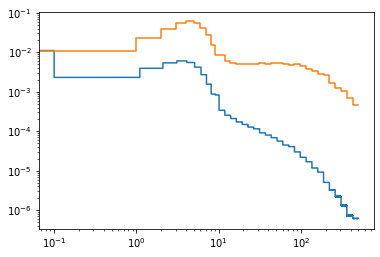

In [154]:
photons_per_bin_new = np.diff(np.concatenate([[0], ipol]))[:-1]

plt.step(new_binning, np.append(photons_per_bin_new, photons_per_bin_new[-1]), where="post")
plt.step(binning, 1E10*rev_trafo(np.append(nn_out, nn_out[-1])), where="post")

plt.loglog()

np.sum(photon_integral) / np.sum(photons_per_bin_new)

In [114]:
ipol[0], photon_integral[0]


(DeviceArray(0.01107092, dtype=float32),
 DeviceArray(0.01107092, dtype=float32))

[]

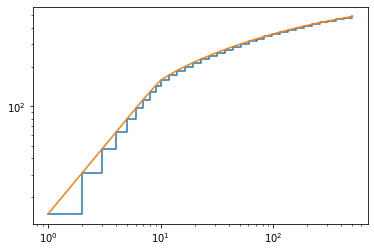

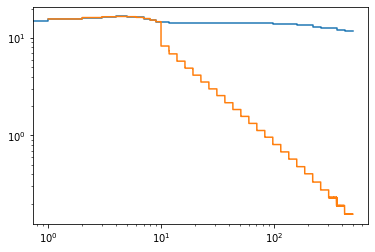

In [95]:
integral = np.cumsum(nn_out)


plt.step(binning[1:], integral, where="post")

new_binning = jnp.linspace(0, 500, 10000)
nbc = 0.5*(new_binning[1:] + new_binning[:-1])

ipol= interpolate_hist(integral, binning[1:], new_binning)
plt.plot(new_binning, ipol)
plt.loglog()

plt.figure()
plt.step(binning, np.append(nn_out, nn_out[-1]), where="post")

nhist = np.diff(ipol) / np.diff(new_binning)

plt.step(new_binning, np.append(nhist, nhist[-1]), where="post")
plt.loglog()


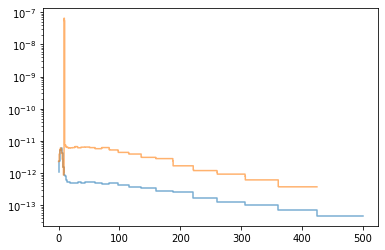

In [29]:
net_in = test_data[ixs[1]]
nn_out = net_eval_fn(net_in)[0]
truth = net_in[1][0]

cum = jnp.cumsum(nn_out*np.diff(binning))

fig, ax = plt.subplots()

ax.step(binning, rev_trafo(np.append(nn_out, nn_out[-1])), alpha=0.6, label="Prediction", where="post")

new_binning = jnp.linspace(0, 500, 1000)

ipolsted = np.diff(interpolate_hist(cum, binning, new_binning)) / np.diff(new_binning)

ax.step(new_binning, rev_trafo(np.append(ipolsted, ipolsted[-1])), alpha=0.6, label="Prediction", where="post")
ax.set_yscale("log")